In [1]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import numpy as np
tfd = tf.contrib.distributions
import matplotlib.pyplot as plt
import gensim
tf.enable_eager_execution()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
from tensorflow.keras import layers, Input
from tensorflow.keras.models import Sequential

In [2]:
from visualization import *
from data import *
from autoencoder_keras import *

### Word 2 vec

In [3]:
# Load Google's pre-trained Word2Vec model.
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True, limit=150000)

embedding_mat, labels = create_embedding_matrix(model)

In [4]:
# define data size parameters
vec_size = model.vector_size
vocab_size = len(model.vocab)

In [5]:
# parameters for splitting the data
train_size = int(vocab_size*0.8)
test_size = int(vocab_size*0.2)
indices = np.arange(0, vocab_size)
np.random.shuffle(indices)

In [6]:
# split the data into train and test
train_w2v_x = embedding_mat[indices[0:train_size]]
train_w2v_y = labels[indices[0:train_size]]
test_w2v_x = embedding_mat[indices[train_size:vocab_size]]
test_w2v_y = labels[indices[train_size:vocab_size]]

In [8]:
batch_size = 256
input_dimension = vec_size
latent_dimension = 2

In [9]:
# Define activation to be used in layers
activation = tf.keras.layers.LeakyReLU()

In [10]:
# Define hidden dimensions
h1 = 210
h2 = 140
h3 = 70
h4 = 90
h5 = 20

In [11]:
# Parameters of model
learn_rate = 1e-4
optimizer = tf.keras.optimizers.Adam(learn_rate)
mse = tf.keras.losses.MeanSquaredError()

In [12]:
# create encoder and decoder
num_layers = 4
input_data, encoded = encoder(input_dimension, h1, h2, h3, h4, h5, latent_dimension, activation, num_layers)
decoded = decoder(input_dimension, h1, h2, h3, h4, h5, encoded, activation, num_layers)

In [13]:
autoencoder_model = tf.keras.Model(input_data, decoded) # define autoencoder model

encoder = tf.keras.Model(input_data, encoded) # encoder, defined to visualize the latent space

autoencoder_model.compile(optimizer=optimizer, loss=mse) # compile model

In [14]:
# print the architecture
autoencoder_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
dense (Dense)                (None, 210)               63210     
_________________________________________________________________
batch_normalization (BatchNo (None, 210)               840       
_________________________________________________________________
dense_1 (Dense)              (None, 140)               29540     
_________________________________________________________________
batch_normalization_1 (Batch (None, 140)               560       
_________________________________________________________________
dense_2 (Dense)              (None, 70)                9870      
_________________________________________________________________
batch_normalization_2 (Batch (None, 70)                280   

In [15]:
x_train = train_w2v_x # train
x_test = test_w2v_x # validation

history = autoencoder_model.fit(x_train, x_train,
                epochs=10, # number of epochs
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 120000 samples, validate on 30000 samples
Epoch 1/10
120000/120000 [==============================] - 6s 50us/sample - loss: 0.0020 - val_loss: 7.0416e-04
Epoch 2/10
120000/120000 [==============================] - 4s 37us/sample - loss: 2.4422e-04 - val_loss: 0.0039
Epoch 3/10
120000/120000 [==============================] - 4s 34us/sample - loss: 9.4875e-05 - val_loss: 2.1779e-04
Epoch 4/10
120000/120000 [==============================] - 4s 37us/sample - loss: 5.9542e-05 - val_loss: 1.5694e-04
Epoch 5/10
120000/120000 [==============================] - 4s 35us/sample - loss: 4.5196e-05 - val_loss: 1.2195e-04
Epoch 6/10
120000/120000 [==============================] - 4s 36us/sample - loss: 3.7643e-05 - val_loss: 2.7829e-04
Epoch 7/10
120000/120000 [==============================] - 4s 37us/sample - loss: 3.4472e-05 - val_loss: 6.7700e-05
Epoch 8/10
120000/120000 [==============================] - 5s 38us/sample - loss: 3.1572e-05 - val_loss: 5.4524e-05
Epoch 9/10
120000/120

### Plotting loss functions

Text(0.5, 0, 'Epoch')

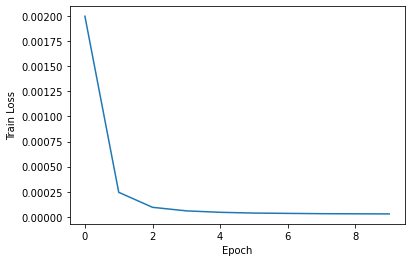

In [17]:
# plot train loss
plt.plot(history.history['loss'])
plt.ylabel('Train Loss')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

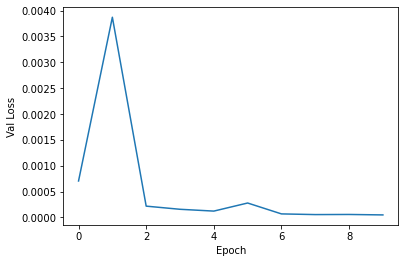

In [18]:
# plot validation loss
plt.plot(history.history['val_loss'])
plt.ylabel('Val Loss')
plt.xlabel('Epoch')

In [20]:
#define filename to use while saving plots
filename = "leakyrelu_batch256_notag_" + str(int(learn_rate*10000))+"e-4" + "_"+str(h1) + "_"+str(h2) + "_"+ str(h3) + "_"+ str(h5)+"_testing2_10epochs"

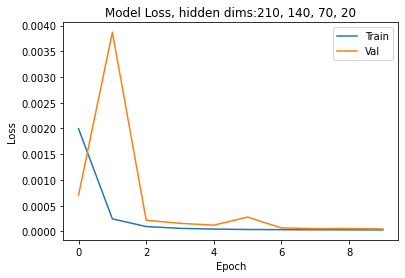

In [21]:
# Plot loss functions
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss, hidden dims:'+str(h1) + ", "+str(h2) + ", "+ str(h3)  + ", "+ str(h5))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.savefig("loss_"+filename)
plt.show()

## Predicting test data

In [22]:
# test class labels as array
word_array = ['Taylor_Swift', 'horizon', 'socks', 'God', 'fairy', 'Kanye_West', 'trump', 'Hollywood', 'ghost', 'dragon', 
              'Sinatra', 'Hulk', 'beach', 'Los_Angeles', 'New_York', 'horrible', 'dumb', 'Star_Wars', 'fashion', 'Chanel', 
              'fantasy', 'movies', 'Lebron', 'basketball', 'tennis', 'president', 'chocolate','language', 'computer', 
              'space', 'game', 'kebab', 'evil', 'surgeon', 'Batman', 'Facebook', 'culinary', 'Pilates', 'clown', 'queen', 
              'Turkey', 'guitar', 'education', 'useful', 'sleep', 'coffee', 'ocean', 'theater', 'Germany','tequila', 'soldier', 
              'biology', 'key','aquarium', 'engineer', 'lavender','Harry_Potter', 'sweater', 'dog', 'lipstick', 'pencil', 
              'Muse', 'neighbor', 'muffin', 'koala', 'zebra', 'oxygen', 'rainforest', 'Einstein', 'medical', 'Metallica']
# creating the test set, vl is the word embeddings
bl, vl, label_list = create_corpus(word_array, 1000, model) #test data

In [23]:
# predict calculate mean square error of test set
k = autoencoder_model.predict(vl)
mse(vl, k).numpy()

0.013175974

In [24]:
gen_data = encoder.predict(vl) # generate latent space using encoder only

## Plotting the latent space

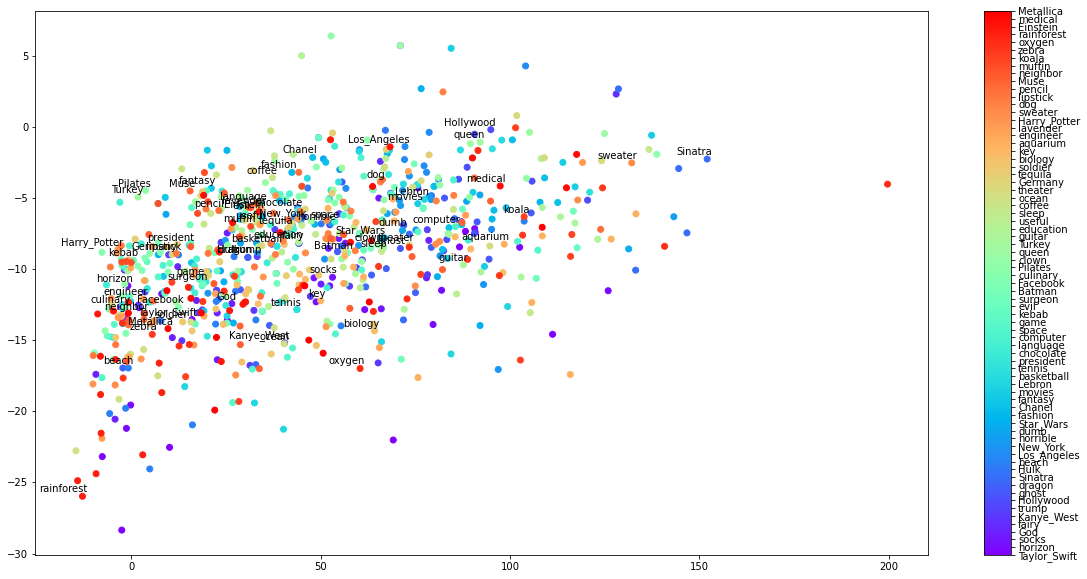

In [25]:
# plot the latent space
plot_embedding(gen_data, bl, label_list, text_data=True, p=11, figsize=(20,10), name="ae_"+filename)